In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('C://work/dev/python/progs/texts/sec_bert/')

In [ ]:
from src.train_eval_model import metric_multi

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score, precision_score, recall_score

import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk import word_tokenize
import joblib

from sklearn.preprocessing import MultiLabelBinarizer
from pandarallel import pandarallel


from ruamel.yaml import YAML

conf = YAML().load(open('params.yaml'))

np.random.seed(conf['seed'])

# Загрузка данных

In [7]:
feat_data = pd.read_csv(conf['feat_eng']['feat_final_fn'])
mlb = joblib.load(conf['prep_text']['mlb_fn'])
data = pd.read_csv(conf['feat_gen']['data_fn'])

data['target'] = data['target'].map(lambda x: eval(x))

data['labels'] = data['labels'].map(lambda x: eval(x))

label2tactic = joblib.load('data/label2tactic.pkl')



clf_pipe = joblib.load(conf['train_eval_model']['model_fn'])

In [8]:
tr_idx = data.query('split=="tr"').index
val_idx = data.query('split=="val"').index
ts_idx = data.query('split=="ts"').index

# Оценка

## подбор порогов 

In [18]:
idx = tr_idx
res_d = {}

preds = (clf_pipe.predict_proba(feat_data.loc[idx]))
y_true = mlb.transform(data.loc[idx, 'labels'])

logreg_thresh_l = []
num_cls = preds.shape[1]

C:\tools\Anaconda3\envs\pytorch_env\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


In [21]:
p, r, f1, _ = precision_recall_fscore_support(y_true, (preds>0.5).astype(int), average='micro')
f1

0.43079674337615886

In [22]:
for i in range(num_cls):
    res_metrics_l = []
    for thresh in np.arange(0.05, 0.95, 0.05):
        
        y_i = y_true[:,i]
        pred_i = (preds[:,i]>thresh).astype(int)
        p, r, f1, sup = [it[1] for it in precision_recall_fscore_support(y_i, pred_i)]

        res_metrics_df = pd.DataFrame({'precision':p, 'recall':r, 'f1':f1, 'sup':sup}, index=[thresh])
        res_metrics_l.append(res_metrics_df)


    res_d[i] = pd.concat([it for it in res_metrics_l], axis=0)
    logreg_thresh_l.append(res_d[i].index[res_d[i]['f1'].argmax()].round(3))

preds = np.apply_along_axis(lambda x: x>=x[-1], 0, np.vstack([preds, logreg_thresh_l]))[:-1].astype(int)

C:\tools\Anaconda3\envs\pytorch_env\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\tools\Anaconda3\envs\pytorch_env\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\tools\Anaconda3\envs\pytorch_env\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\tool

In [23]:
p, r, f1, _ = precision_recall_fscore_support(y_true, preds, average='micro')
f1

0.6301072467543746

## оценка

In [26]:
from src.train_eval_model import metric_multi
from sklearn.metrics import average_precision_score

Y_proba = clf_pipe.predict_proba(feat_data.loc[val_idx])
Y_val_true = mlb.transform(data.loc[val_idx, 'labels'])

metric_multi(Y_val_true, Y_proba, average_precision_score)[0]

C:\tools\Anaconda3\envs\pytorch_env\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


0.5167983630886614

In [27]:
p, r, f1, _ = precision_recall_fscore_support(Y_val_true, (Y_proba>0.5).astype(int), average='micro')
f1

0.4316006755488835

### с выбранным порогом

In [28]:
logreg_val_probas = (clf_pipe.predict_proba(feat_data.loc[val_idx]))
Y_val_true = mlb.transform(data.loc[val_idx, 'labels'])

logreg_val_preds = np.apply_along_axis(lambda x: x>=x[-1], 0, np.vstack([logreg_val_probas, logreg_thresh_l]))[:-1].astype(int)
p, r, f1, _ = precision_recall_fscore_support(Y_val_true, logreg_val_preds, average='micro')
f1

C:\tools\Anaconda3\envs\pytorch_env\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


0.6110069858578975

In [17]:
logreg_ts_probas = (clf_pipe.predict_proba(feat_data.loc[ts_idx]))
Y_ts_true = mlb.transform(data.loc[ts_idx, 'labels'])

logreg_ts_preds = np.apply_along_axis(lambda x: x>=x[-1], 0, np.vstack([logreg_ts_probas, logreg_thresh_l]))[:-1].astype(int)
p, r, f1, _ = precision_recall_fscore_support(Y_ts_true, logreg_ts_preds, average='micro')
f1

C:\tools\Anaconda3\envs\pytorch_env\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


0.6290574553028988

#### где лучше

In [215]:
logreg_pr_val_l = metric_multi(Y_val_true, logreg_val_probas, average_precision_score)[1]

logreg_pr_ts_l = metric_multi(Y_ts_true, logreg_ts_probas, average_precision_score)[1]

### с sci bert-ом

In [27]:
probs_val = joblib.load('data/probs_val_sec_bert.pkl')
probs_tr = joblib.load('data/probs_tr_sec_bert.pkl')
probs_ts = joblib.load('data/probs_ts_sec_bert.pkl')

In [59]:
thresh_mod_l = np.array(logreg_thresh_l)+0.5

In [60]:
preds = (clf_pipe.predict_proba(feat_data.loc[val_idx]))
y_true = mlb.transform(data.loc[val_idx, 'labels'])

preds = probs_val+preds

preds = np.apply_along_axis(lambda x: x>=x[-1], 0, np.vstack([preds, thresh_mod_l]))[:-1].astype(int)
p, r, f1, _ = precision_recall_fscore_support(y_true, preds, average='micro')
f1

0.6728395061728395

In [61]:
preds = (clf_pipe.predict_proba(feat_data.loc[ts_idx]))
y_true = mlb.transform(data.loc[ts_idx, 'labels'])

preds = preds+probs_ts

preds = np.apply_along_axis(lambda x: x>=x[-1], 0, np.vstack([preds, thresh_mod_l]))[:-1].astype(int)
p, r, f1, _ = precision_recall_fscore_support(y_true, preds, average='micro')
f1

0.6666666666666666

### подбор порога в sci bert

In [36]:
probs_val = joblib.load('data/probs_val_sec_bert.pkl')
probs_tr = joblib.load('data/probs_tr_sec_bert.pkl')
probs_ts = joblib.load('data/probs_ts_sec_bert.pkl')

In [37]:
from sklearn.metrics import precision_recall_fscore_support

idx = tr_idx
res_d = {}

preds = probs_tr
y_true = mlb.transform(data.loc[idx, 'labels'])

bert_thresh_l = []
num_cls = preds.shape[1]

In [38]:
for i in range(num_cls):
    res_metrics_l = []
    for thresh in np.arange(0.05, 0.95, 0.05):
        
        y_i = y_true[:,i]
        pred_i = (preds[:,i]>thresh).astype(int)
        # import pdb;pdb.set_trace()
        p, r, f1, sup = [it[1] for it in precision_recall_fscore_support(y_i, pred_i)]

        res_metrics_df = pd.DataFrame({'precision':p, 'recall':r, 'f1':f1, 'sup':sup}, index=[thresh])
        res_metrics_l.append(res_metrics_df)


    res_d[i] = pd.concat([it for it in res_metrics_l], axis=0)
    bert_thresh_l.append(res_d[i].index[res_d[i]['f1'].argmax()].round(3))

preds = np.apply_along_axis(lambda x: x>=x[-1], 0, np.vstack([preds, bert_thresh_l]))[:-1].astype(int)

C:\tools\Anaconda3\envs\pytorch_env\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\tools\Anaconda3\envs\pytorch_env\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\tools\Anaconda3\envs\pytorch_env\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\tool

In [39]:
p, r, f1, _ = precision_recall_fscore_support(y_true, preds, average='micro')
f1

0.9407850964737192

In [40]:
bert_val_preds = np.apply_along_axis(lambda x: x>=x[-1], 0, np.vstack([probs_val, bert_thresh_l]))[:-1].astype(int)
p, r, f1, _ = precision_recall_fscore_support(Y_val_true, bert_val_preds, average='micro')
f1

0.7368421052631579

In [43]:
metric_multi(Y_val_true, probs_val, average_precision_score)[0]

0.7010434942376583

In [41]:
bert_ts_preds = np.apply_along_axis(lambda x: x>=x[-1], 0, np.vstack([probs_ts, bert_thresh_l]))[:-1].astype(int)
p, r, f1, _ = precision_recall_fscore_support(Y_ts_true, bert_ts_preds, average='micro')
f1

0.7180851063829787

#### смесь с логрегом по ошибка f1

In [203]:
bert_pr_val_l = np.array(metric_multi(Y_val_true, bert_val_preds, f1_score)[1])
logreg_pr_val_l = np.array(metric_multi(Y_val_true, logreg_val_preds, f1_score)[1])

In [206]:
np.array(metric_multi(Y_val_true, comb_val_preds, f1_score)[1])

array([0.8       , 0.44444444, 0.        , 0.75      , 0.93333333,
       0.46666667, 0.625     , 0.        , 0.75      , 0.5       ,
       0.66666667, 0.8       , 0.85714286, 0.5       , 0.87179487,
       0.        , 0.        , 0.33333333, 0.        , 0.        ,
       0.625     , 0.78787879, 0.        , 0.        , 0.        ,
       0.7826087 , 0.90909091, 0.        , 1.        , 0.66666667,
       0.88235294, 0.        , 0.75      , 0.        , 1.        ,
       0.5       , 0.4       , 0.        , 0.66666667, 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       0.85714286, 0.8       , 0.66666667, 0.66666667, 0.        ])

In [207]:
idx_to_combine = np.where(bert_pr_val_l<logreg_pr_val_l)[0]
idx_to_combine

array([ 6, 36, 44], dtype=int64)

In [208]:
mod_thresh_l = np.array(bert_thresh_l)
mod_thresh_l[idx_to_combine] = np.array(logreg_thresh_l)[idx_to_combine] 

# меняем колонки с предсказаниями и thresh в берт из логрега
comb_val_probas = probs_val.copy()
comb_val_probas[:, idx_to_combine] = logreg_val_probas[:, idx_to_combine]

In [209]:
comb_val_preds = np.apply_along_axis(lambda x: x>=x[-1], 0, np.vstack([comb_val_probas, mod_thresh_l]))[:-1].astype(int)
p, r, f1, _ = precision_recall_fscore_support(Y_val_true, comb_val_preds, average='micro')
f1

0.7454068241469817

In [222]:

# меняем колонки с предсказаниями и thresh в берт из логрега
comb_ts_probas = probs_ts.copy()
comb_ts_probas [:, idx_to_combine] = logreg_ts_probas[:, idx_to_combine]

In [223]:
comb_ts_preds = np.apply_along_axis(lambda x: x>=x[-1], 0, np.vstack([comb_ts_probas, mod_thresh_l]))[:-1].astype(int)
p, r, f1, _ = precision_recall_fscore_support(Y_ts_true, comb_ts_preds, average='micro')
f1

0.7146666666666667

#### смесь с логрегом

In [216]:
bert_pr_val_l = metric_multi(Y_val_true, probs_val, average_precision_score)[1]
bad_bert_pr_val_l = np.where(np.array(bert_pr_val_l)<0.4)[0]
bad_bert_pr_val_l

array([ 2,  7, 13, 15, 16, 18, 19, 22, 24, 27, 33, 37, 41, 42, 49],
      dtype=int64)

In [217]:
np.array(bert_pr_val_l)[bad_bert_pr_val_l]

array([0.        , 0.        , 0.32692308, 0.0799458 , 0.125     ,
       0.        , 0.29166667, 0.03571429, 0.        , 0.25      ,
       0.08545455, 0.20833333, 0.02702703, 0.        , 0.        ])

In [218]:
idx_inlog_reg = np.where(np.array(logreg_pr_val_l)[bad_bert_pr_val_l]>np.array(bert_pr_val_l)[bad_bert_pr_val_l])[0]
idx_inlog_reg

array([ 3,  4, 10, 11, 12], dtype=int64)

In [219]:
idx_to_combine = bad_bert_pr_val_l[idx_inlog_reg]
idx_to_combine

array([15, 16, 33, 37, 41], dtype=int64)

In [220]:
mod_thresh_l = np.array(bert_thresh_l)
mod_thresh_l[idx_to_combine] = np.array(logreg_thresh_l)[idx_to_combine] 

# меняем колонки с предсказаниями и thresh в берт из логрега
comb_val_probas = probs_val.copy()
comb_val_probas[:, idx_to_combine] = logreg_val_probas[:, idx_to_combine]


In [221]:
comb_val_preds = np.apply_along_axis(lambda x: x>=x[-1], 0, np.vstack([comb_val_probas, mod_thresh_l]))[:-1].astype(int)
p, r, f1, _ = precision_recall_fscore_support(Y_val_true, comb_val_preds, average='micro')
f1

0.7329842931937173

### модель без порога 

In [29]:
p, r, f1_val, _ = precision_recall_fscore_support(mlb.transform(data.loc[val_idx, 'labels']), clf_pipe.predict(feat_data.loc[val_idx]), average='micro')
p, r, f1_ts, _ = precision_recall_fscore_support(mlb.transform(data.loc[ts_idx, 'labels']), clf_pipe.predict(feat_data.loc[ts_idx]), average='micro')

f1_val, f1_ts

C:\tools\Anaconda3\envs\pytorch_env\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
C:\tools\Anaconda3\envs\pytorch_env\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


(0.4316006755488835, 0.4286522148916117)

## сопоставление финальных прогнозов

In [18]:
preds_proba = (clf_pipe.predict_proba(feat_data.loc[ts_idx]))
preds_proba = np.apply_along_axis(lambda x: x>=x[-1], 0, np.vstack([preds, logreg_thresh_l]))[:-1].astype(int)

In [19]:
mlb.inverse_transform(preds_proba)

[('T1027', 'T1055', 'T1106', 'T1140'),
 ('T1012',
  'T1016',
  'T1033',
  'T1036.005',
  'T1047',
  'T1082',
  'T1083',
  'T1573.001'),
 ('T1059.003', 'T1543.003'),
 ('T1021.001', 'T1078', 'T1090'),
 ('T1059.003',),
 ('T1059.003',),
 ('T1059.003',),
 ('T1078',),
 ('T1083',),
 ('T1082', 'T1105'),
 ('T1021.001', 'T1078', 'T1570'),
 ('T1021.001', 'T1090', 'T1570'),
 ('T1021.001', 'T1078', 'T1090', 'T1110', 'T1570'),
 ('T1047', 'T1059.003', 'T1562.001'),
 ('T1059.003', 'T1070.004', 'T1570'),
 ('T1059.003',),
 ('T1027', 'T1140'),
 ('T1021.001', 'T1078', 'T1090'),
 ('T1027', 'T1204.002', 'T1566.001'),
 ('T1059.003', 'T1105'),
 (),
 ('T1016', 'T1056.001', 'T1083'),
 (),
 ('T1005', 'T1016', 'T1033', 'T1082'),
 ('T1027', 'T1140'),
 ('T1110', 'T1204.002', 'T1566.001'),
 ('T1027', 'T1059.003', 'T1105'),
 (),
 ('T1106',),
 (),
 (),
 ('T1016', 'T1057', 'T1082'),
 ('T1027', 'T1055', 'T1140'),
 ('T1012', 'T1082', 'T1547.001', 'T1573.001'),
 ('T1027', 'T1140'),
 ('T1027', 'T1055', 'T1140'),
 (),
 ('T1

In [20]:
mlb.inverse_transform(clf_pipe.predict(feat_data.loc[ts_idx]))

[(),
 ('T1059.003', 'T1105'),
 ('T1021.001', 'T1059.003', 'T1570'),
 (),
 ('T1140',),
 ('T1055',),
 ('T1027',),
 ('T1027', 'T1140'),
 ('T1140',),
 ('T1027', 'T1140'),
 (),
 ('T1021.001',),
 ('T1021.001',),
 ('T1106',),
 ('T1027', 'T1106'),
 (),
 ('T1027', 'T1105'),
 ('T1059.003', 'T1204.002', 'T1564.001'),
 ('T1140',),
 (),
 ('T1027', 'T1140'),
 (),
 ('T1003.001', 'T1055'),
 (),
 (),
 ('T1027', 'T1106', 'T1140'),
 ('T1027', 'T1140'),
 (),
 ('T1059.003',),
 (),
 (),
 ('T1027',),
 (),
 ('T1059.003',),
 (),
 ('T1105',),
 ('T1055',),
 (),
 ('T1140',),
 (),
 ('T1027', 'T1140'),
 (),
 ('T1003.001', 'T1055'),
 (),
 ('T1105', 'T1140'),
 (),
 ('T1059.003',),
 ('T1027', 'T1140'),
 (),
 (),
 ('T1112',),
 (),
 (),
 ('T1021.001',),
 (),
 (),
 ('T1055', 'T1070.004', 'T1106'),
 (),
 ('T1059.003',),
 ('T1059.003',),
 ('T1059.003', 'T1112'),
 (),
 (),
 (),
 ('T1027', 'T1140'),
 ('T1055',),
 ('T1027', 'T1140'),
 ('T1055', 'T1106'),
 ('T1140',),
 ('T1027', 'T1140'),
 ('T1059.003', 'T1112', 'T1562.001'),


## dummy модель

Прогнозируем по процентам так же по классам

In [31]:
prob_pclass = mlb.transform(data.loc[data.split=='tr', 'labels']).mean(axis=0)

def gen_synth_proba(size, prob_pclass):
    ar_l = []
    for i in range(size[1]):
        ar_l.append(np.random.choice([0,1], size=(size[0],), p=[1-prob_pclass[i], prob_pclass[i]]).reshape(-1, 1))

    return np.hstack(ar_l)



In [34]:
(data.split=='val').sum()

2403

In [35]:
preds_synth_val = gen_synth_proba(size=(int((data.split=='val').sum()), len(mlb.classes_)), prob_pclass=prob_pclass)
preds_synth_ts = gen_synth_proba(size=(int((data.split=='ts').sum()), len(mlb.classes_)), prob_pclass=prob_pclass)

p, r, f1_val, _ = precision_recall_fscore_support(mlb.transform(data.loc[val_idx, 'labels']), preds_synth_val, average='micro')
p, r, f1_ts, _ = precision_recall_fscore_support(mlb.transform(data.loc[ts_idx, 'labels']), preds_synth_ts, average='micro')
f1_val, f1_ts

(0.13333333333333333, 0.1377361822355642)

В экзекьютере создается пандас датафрейм, который хочу сохранить в hdfs не перенося данные в драйвер, как это можно сделать 

# Эксперименты

# Тест на созависимость между таргетами

In [26]:

pairs_l = []
for val in data['labels'].tolist():
    if len(val)>1:
        for i in range(len(val)-1):
            for j in range(i+1, len(val)):
                pairs_l.append((val[i], val[j]))
    

In [33]:
res_df = pd.DataFrame(pairs_l, columns=['cls1', 'cls2']).groupby(['cls1', 'cls2'], as_index=False).size()

In [34]:
cross_tab = res_df.pivot(index='cls1', columns='cls2', values='size').fillna(0).sort_index(axis=0).sort_index(axis=1)
cross_tab

cls2,T1003.001,T1005,T1012,T1016,T1021.001,T1027,T1033,T1036.005,T1041,T1047,...,T1518.001,T1543.003,T1547.001,T1548.002,T1562.001,T1564.001,T1566.001,T1569.002,T1570,T1573.001
cls1,,,,,,,,,,,,,,,,,,,,,
T1003.001,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T1005,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T1012,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T1016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
T1021.001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T1027,5.0,0.0,0.0,1.0,0.0,0.0,1.0,7.0,1.0,0.0,...,0.0,2.0,3.0,1.0,3.0,1.0,4.0,0.0,1.0,1.0
T1033,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T1036.005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T1041,1.0,3.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0


In [35]:
from scipy.stats import chi2_contingency

hi, p, _, _ = chi2_contingency(cross_tab)
hi, p

(5352.517392914262, 3.324222057424821e-279)

# почему roc_auc плохая оценка

In [207]:
thresh_l[4]

0.3

In [208]:
res_d[4]

,precision,recall,f1,sup
0.05,0.281818,0.911765,0.430556,34
0.10,0.402778,0.852941,0.547170,34
0.15,0.500000,0.764706,0.604651,34
0.20,0.571429,0.705882,0.631579,34
0.25,0.628571,0.647059,0.637681,34
0.30,0.677419,0.617647,0.646154,34
0.35,0.666667,0.588235,0.625000,34
0.40,0.655172,0.558824,0.603175,34
0.45,0.703704,0.558824,0.622951,34
0.50,0.782609,0.529412,0.631579,34


In [209]:
i = 4

y_i = y_true[:,i]
pred_i = (preds[:,i]>thresh).astype(int)

p, r, f1, sup = [it[1] for it in precision_recall_fscore_support(y_i, pred_i)]
f1

0.6461538461538462

In [210]:
roc_auc_score(y_i, preds[:,i])

0.8008995991423511

In [219]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_i, preds[:,i], pos_label=1)
fpr, tpr, thresholds

(array([0.        , 0.01584786, 1.        ]),
 array([0.        , 0.61764706, 1.        ]),
 array([inf,  1.,  0.]))

In [200]:
metric_multi(y_true, preds, roc_auc_score)

(0.6840646847163215,
 [0.6627846790890269,
  0.6655927086961568,
  0.4923780487804878,
  0.5695736434108527,
  0.8008995991423511,
  0.7307055659010966,
  0.6375968992248062,
  0.6564088598402325,
  0.7798273155416012,
  0.7369344773790952,
  0.6468039003250271,
  0.8436974789915966,
  0.7621037965865552,
  0.6947161488300729,
  0.8074419648582788,
  0.5,
  0.6744186046511628,
  0.7512038523274478,
  0.5,
  0.49924471299093653,
  0.6663082437275986,
  0.6877049180327869,
  0.8393700787401576,
  0.7288457740916271,
  0.5488769780500254,
  0.7535087719298246,
  0.7141482945091514,
  0.5765048052604957,
  0.6828197624375969,
  0.73734375,
  0.8353630514705883,
  0.5825757575757575,
  0.8003860219422999,
  0.6659079413252402,
  0.61296875,
  0.5983637747336378,
  0.7811550151975684,
  0.686172722982539,
  0.6710662525879917,
  0.6211479198767335,
  0.5757460799190693,
  0.5,
  0.5,
  0.7210518874593526,
  0.7826747720364742,
  0.8018433179723504,
  0.6749374478732277,
  0.7868217054263567,

roc_auc - fpr=(fp)/(tn+fp) медленно реагирует на изменение tpr, так как найден еще класс положительный при очередном пороге recall сильно подскакивает, пусть ошибки будут, но за счет большого количества tn fpr будет тормозить

#### prec_recall

У нас задача с несбалансированными классами 1/40. Какое значение average_precision_score при случайном угадывании будет

0.437954944286713


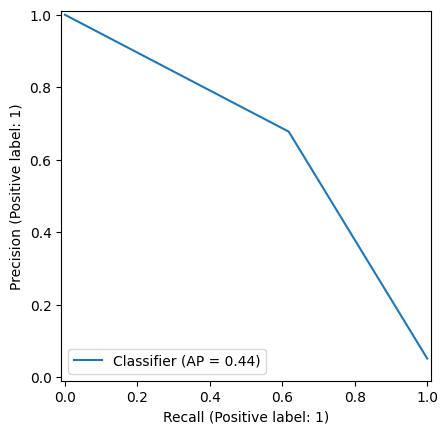

In [218]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

print(average_precision_score(y_i, preds[:,i]))


In [221]:
metric_multi(y_true, preds, average_precision_score)

(0.1799586475962232,
 [0.21549707602339183,
  0.1313840155945419,
  0.013533834586466165,
  0.07056390977443608,
  0.437954944286713,
  0.4397624030500174,
  0.10287081339712917,
  0.08271782397169394,
  0.17801546118818173,
  0.07825332562174668,
  0.17186404926343007,
  0.5712007290954659,
  0.25614035087719295,
  0.19355459355459353,
  0.40238416948355293,
  0.0030075187969924814,
  0.09609389326975978,
  0.2317585007294355,
  0.0015037593984962407,
  0.004511278195488722,
  0.18482131254061077,
  0.2874618979882138,
  0.19912156629196753,
  0.3451661825017088,
  0.022129792566522692,
  0.4237483953786906,
  0.1870631536942916,
  0.02418546365914787,
  0.27537270695165433,
  0.17899749373433585,
  0.6727111897390534,
  0.014348370927318296,
  0.2158344230140569,
  0.22823725981620718,
  0.12457142857142857,
  0.02253606990449096,
  0.23308270676691728,
  0.15995906927081016,
  0.11190096453254347,
  0.129156223893066,
  0.022670312143996355,
  0.0015037593984962407,
  0.001503759398

## roc исследование

In [95]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(Y_true[:,0], Y_proba[:,0], pos_label=1)

In [96]:
thresholds, tpr, fpr

(array([       inf, 0.16897172, 0.0739391 , 0.07026845, 0.05694045,
        0.05676364, 0.04146554, 0.03955192, 0.00041691]),
 array([0.        , 0.        , 0.        , 0.33333333, 0.33333333,
        0.66666667, 0.66666667, 1.        , 1.        ]),
 array([0.    , 0.0125, 0.05  , 0.05  , 0.0875, 0.0875, 0.125 , 0.125 ,
        1.    ]))

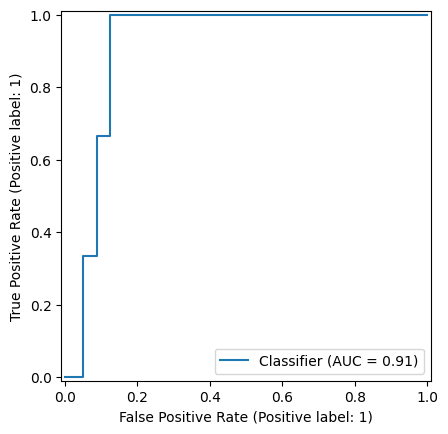

In [97]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(Y_true[:,0], Y_proba[:,0])

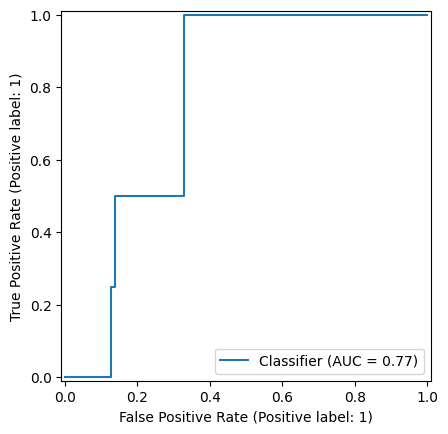

In [98]:
RocCurveDisplay.from_predictions(Y_true[:,1], Y_proba[:,1])

In [99]:
roc_auc_score(Y_true[:,0], Y_proba[:,0])

0.9125

# Остальное

## Где сигнатуры

In [39]:
data = pd.read_csv(conf['feat_gen']['data_fn'])

data['labels'] = data['labels'].map(lambda x: eval(x))
data['threat_words'] = data['threat_words'].map(lambda x: eval(x))
data['threat_words'] = data['threat_words'].apply(lambda x: ' '.join(x))

In [52]:
from sklearn.feature_extraction.text import CountVectorizer
from src.feat_gen import custom_tok

vec = CountVectorizer(tokenizer=custom_tok, binary=True, min_df=1)
vec.fit(data.loc[data['train']==1, 'threat_words'])

feat_ind = pd.DataFrame(vec.transform(data['threat_words']).toarray(), columns=vec.get_feature_names_out())

C:\tools\Anaconda3\envs\pytorch_env\lib\site-packages\sklearn\feature_extraction\text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [56]:
[col for col in feat_data.columns if 't1021.002' in col]

['t1021.002']

In [55]:
feat_ind

,t1021.002,t1047,t1106,t1484.001,t1547.001,t1569.002
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
826,0,0,0,0,0,0
827,0,0,0,0,0,0
828,0,0,0,0,0,0
829,0,0,0,0,0,0


In [53]:
feat_data.join(feat_ind)

ValueError: columns overlap but no suffix specified: Index(['t1021.002', 't1047', 't1106', 't1484.001', 't1547.001', 't1569.002'], dtype='object')